# IBM Quantum Experience Lab - Lab script

Please use this notebook as a template for the work that you will submit for assessment for this lab exercise.

Student Names: ENTER YOUR NAMES HERE

## Warm up exercise

In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, Aer
from qiskit.tools.visualization import circuit_drawer
from qiskit import Aer
import matplotlib.pyplot as plt

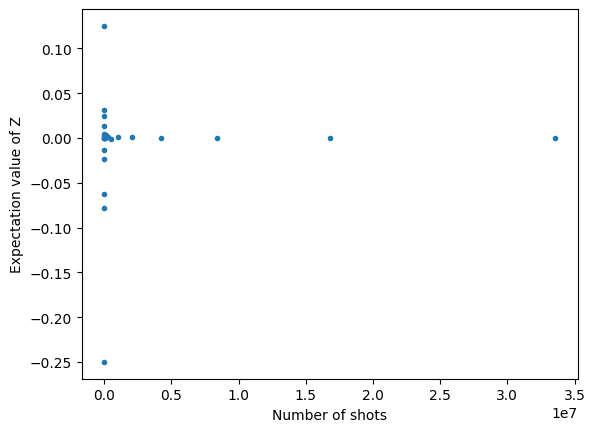

In [15]:
qr = QuantumRegister(1)
cr = ClassicalRegister(1)
circuit = QuantumCircuit(qr, cr)

circuit.h(qr[0])
circuit.measure(qr[0],cr[0])


backend = Aer.get_backend('qasm_simulator')

def get_expectation(result,circuit):
    return (result.get_counts(circuit)['0']-result.get_counts(circuit)['1'])/ (result.get_counts(circuit)['0'] + result.get_counts(circuit)['1'])
                                                                    
expectation_values = []
for n in range(1,26):
    job = execute(circuit, backend,shots=2**n)
    result = job.result()
    expectation_values.append(get_expectation(result,circuit))

plt.plot([n for n in range(1,26)], expectation_values, '.')
plt.xlabel('Number of shots (log scale)')
plt.ylabel('Expectation value of Z')
plt.show()

# Main Lab Exercise

In [74]:
import math
import numpy as np
#Functions
def get_expectation(circuit,backend,logshots):
    job = execute(circuit, backend,shots=2**logshots)
    result = job.result()
    return (result.get_counts(circuit)['0']-result.get_counts(circuit)['1'])/ (result.get_counts(circuit)['0'] + result.get_counts(circuit)['1'])

def get_expectation_distribution(circuit, logshot, backend, draw=False):
    expectation_values = []
    for n in range(1,logshot):
        expectation_values.append(get_expectation(circuit,backend,n))
    if draw == True:
        plt.plot([n for n in range(1,logshot)], expectation_values, '.')
        plt.xlabel('Number of shots (log scale)')
        plt.ylabel('Expectation value of Z')
        plt.show()
        plt.close()
    return expectation_values

def initial_state(phi):
    state = math.cos(phi)*np.array([1,0]) + 1j*math.sin(phi)* np.array([0,1])
    return state


In [75]:
# Method 1 - apply HU^dagger(theta) and measure Z

#Build the cirquit
def method_1_circuit(theta, phi):
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    circuit = QuantumCircuit(qr, cr)
    circuit.initialize(initial_state(phi), qr[0])
    circuit.p(-theta, qr[0])
    circuit.h(qr[0])
    circuit.measure(qr[0],cr[0])
    return circuit

circuit_drawer(method_1_circuit(theta=math.pi/8, phi=math.pi/4))

┌──────────────────────────────┐┌─────────┐┌───┐┌─┐
q1069: ┤ Initialize(0.70711,0.70711j) ├┤ P(-π/8) ├┤ H ├┤M├
       └──────────────────────────────┘└─────────┘└───┘└╥┘
c52: 1/═════════════════════════════════════════════════╩═
                                                        0

In [76]:
backend = Aer.get_backend('qasm_simulator')
circuit = method_1_circuit(theta=math.pi/8, phi=math.pi/4)
get_expectation_distribution(circuit,20,backend)

[0.0,
 0.0,
 0.75,
 0.25,
 0.375,
 0.21875,
 0.34375,
 0.484375,
 0.4296875,
 0.41015625,
 0.3740234375,
 0.400390625,
 0.39453125,
 0.377685546875,
 0.3865966796875,
 0.382598876953125,
 0.3814697265625,
 0.38199615478515625,
 0.3824462890625]

In [45]:
# Method 2
# M(theta) = cos(theta)X + sin(theta)Y
# alpha = cos(theta) ; beta = sin(theta)

#Build the cirquits

#Measure X expectation value circuit
def method_2_X_circuit(theta,phi):
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    circuit = QuantumCircuit(qr, cr)
    circuit.initialize(initial_state(phi), qr[0])
    circuit.h(qr[0])
    circuit.measure(qr[0],cr[0])
    circuit_drawer(circuit)
    return circuit


circuit_drawer(method_2_X_circuit(theta=math.pi/4, phi=0))

┌─────────────────┐┌───┐┌─┐
 q246: ┤ Initialize(1,0) ├┤ H ├┤M├
       └─────────────────┘└───┘└╥┘
c25: 1/═════════════════════════╩═
                                0

In [47]:
#Measure Y expectation value circuit
def method_2_Y_circuit(theta,phi):
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    circuit = QuantumCircuit(qr, cr)
    circuit.initialize(initial_state(phi), qr[0])
    circuit.h(qr[0])
    circuit.p(math.pi/2,qr[0])
    circuit.measure(qr[0],cr[0])
    circuit_drawer(circuit)
    return circuit

circuit_drawer(method_2_Y_circuit(theta=math.pi/4, phi=0))

┌─────────────────┐┌───┐┌────────┐┌─┐
 q247: ┤ Initialize(1,0) ├┤ H ├┤ P(π/2) ├┤M├
       └─────────────────┘└───┘└────────┘└╥┘
c26: 1/═══════════════════════════════════╩═
                                          0

In [73]:
theta=math.pi/8
phi=math.pi/4
shot_range = 20 #log scale
backend = Aer.get_backend('qasm_simulator')
circuit_X = method_2_X_circuit(theta, phi)
expectation_X = get_expectation_distribution(circuit_X,shot_range,backend)
circuit_Y = method_2_Y_circuit(theta,phi)
expectation_Y = get_expectation_distribution(circuit_Y,shot_range,backend)

expectation_M = []
for i in range(len(expectation_X)):
    expectation_M.append(math.cos(theta)*expectation_X[i] + math.sin(theta)*expectation_Y[i])

print(expectation_M)

[0.0, -0.1913417161825449, 0.09567085809127245, -0.529589278773918, -0.38848684305122927, 0.14435617695488856, 0.009482096827329256, 0.1336356999105194, -0.03299309369612239, 0.02291380900334381, 0.012268452315669032, 9.067829197092906e-05, -3.3198821014839355e-05, -0.005753872104212515, 0.0058424876858955725, 0.0038748202731974657, -0.0032985505993015744, 0.0003832675884953091, 0.0006515266299500056]
